### EDA
### Data Cleaning

### Data Validation


Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler


In [2]:
df= pd.read_csv("../DataSet/Churn_Modelling.csv")
df.head()


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Data Validation 

In [3]:
#DATA VALIDATION 

def validate_data(df):
    issues = {}
    
    # Validate negative values in specific columns
    columns_to_check = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
    for column in columns_to_check:
        invalid_values = df[df[column] < 0]
        if not invalid_values.empty:
            issues[column] = invalid_values

    # Logical range checks
    if (df['Age'] > 120).any():
        issues['Age'] = df[df['Age'] > 120]
    if (df['CreditScore'] > 850).any():
        issues['CreditScore'] = df[df['CreditScore'] > 850]

    if issues:
        print("Data Validation Issues Detected:")
        for key, value in issues.items():
            print(f"{key}: {len(value)} invalid rows")
        return issues
    else:
        print("No validation issues detected.")
        return None

# Usage
issues = validate_data(df)


No validation issues detected.


In [4]:
df = df.drop("RowNumber", axis =1)


In [5]:
df = df.drop("CustomerId", axis = 1)


In [6]:
# Replace negative CreditScore values with NaN
df['CreditScore'] = df['CreditScore'].apply(lambda x: x if x >= 0 else np.nan)

# Alternatively, replace NaNs with the median (or mean) of the column
df['CreditScore'].fillna(df['CreditScore'].median(), inplace=True)


/tmp/ipykernel_9024/3004824043.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CreditScore'].fillna(df['CreditScore'].median(), inplace=True)


In [7]:
def data_overview(df):
    print("### Dataset Overview ###")
    print("Shape of the dataset:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nFirst 5 Rows:\n", df.head())

data_overview(df)


### Dataset Overview ###
Shape of the dataset: (10000, 12)

Data Types:
 Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Missing Values:
 Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

First 5 Rows:
     Surname  CreditScore Geography  Gender  Age  Tenure    Balance  \
0  Hargrave          619    France  Female   42       2       0.00   
1      Hill          608     Spain  Female   41       1   83807.86   
2      Onio          502    France  Female   42       8  159660.80   
3      Bon

In [8]:
def five_number_summary(df):
    print("\n### Five-Number Summary ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    summary = df[num_columns].describe(percentiles=[0.25, 0.5, 0.75]).loc[['min', '25%', '50%', '75%', 'max']]
    print(summary)
    return summary

five_number_summary(df)



### Five-Number Summary ###
     CreditScore   Age  Tenure    Balance  NumOfProducts  HasCrCard  \
min        350.0  18.0     0.0       0.00            1.0        0.0   
25%        584.0  32.0     3.0       0.00            1.0        0.0   
50%        652.0  37.0     5.0   97198.54            1.0        1.0   
75%        718.0  44.0     7.0  127644.24            2.0        1.0   
max        850.0  92.0    10.0  250898.09            4.0        1.0   

     IsActiveMember  EstimatedSalary  Exited  
min             0.0          11.5800     0.0  
25%             0.0       51002.1100     0.0  
50%             1.0      100193.9150     0.0  
75%             1.0      149388.2475     0.0  
max             1.0      199992.4800     1.0  


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
min,350.0,18.0,0.0,0.00,1.0,0.0,0.0,11.5800,0.0
25%,584.0,32.0,3.0,0.00,1.0,0.0,0.0,51002.1100,0.0
50%,652.0,37.0,5.0,97198.54,1.0,1.0,1.0,100193.9150,0.0
75%,718.0,44.0,7.0,127644.24,2.0,1.0,1.0,149388.2475,0.0
max,850.0,92.0,10.0,250898.09,4.0,1.0,1.0,199992.4800,1.0



### Numerical Univariate Analysis ###


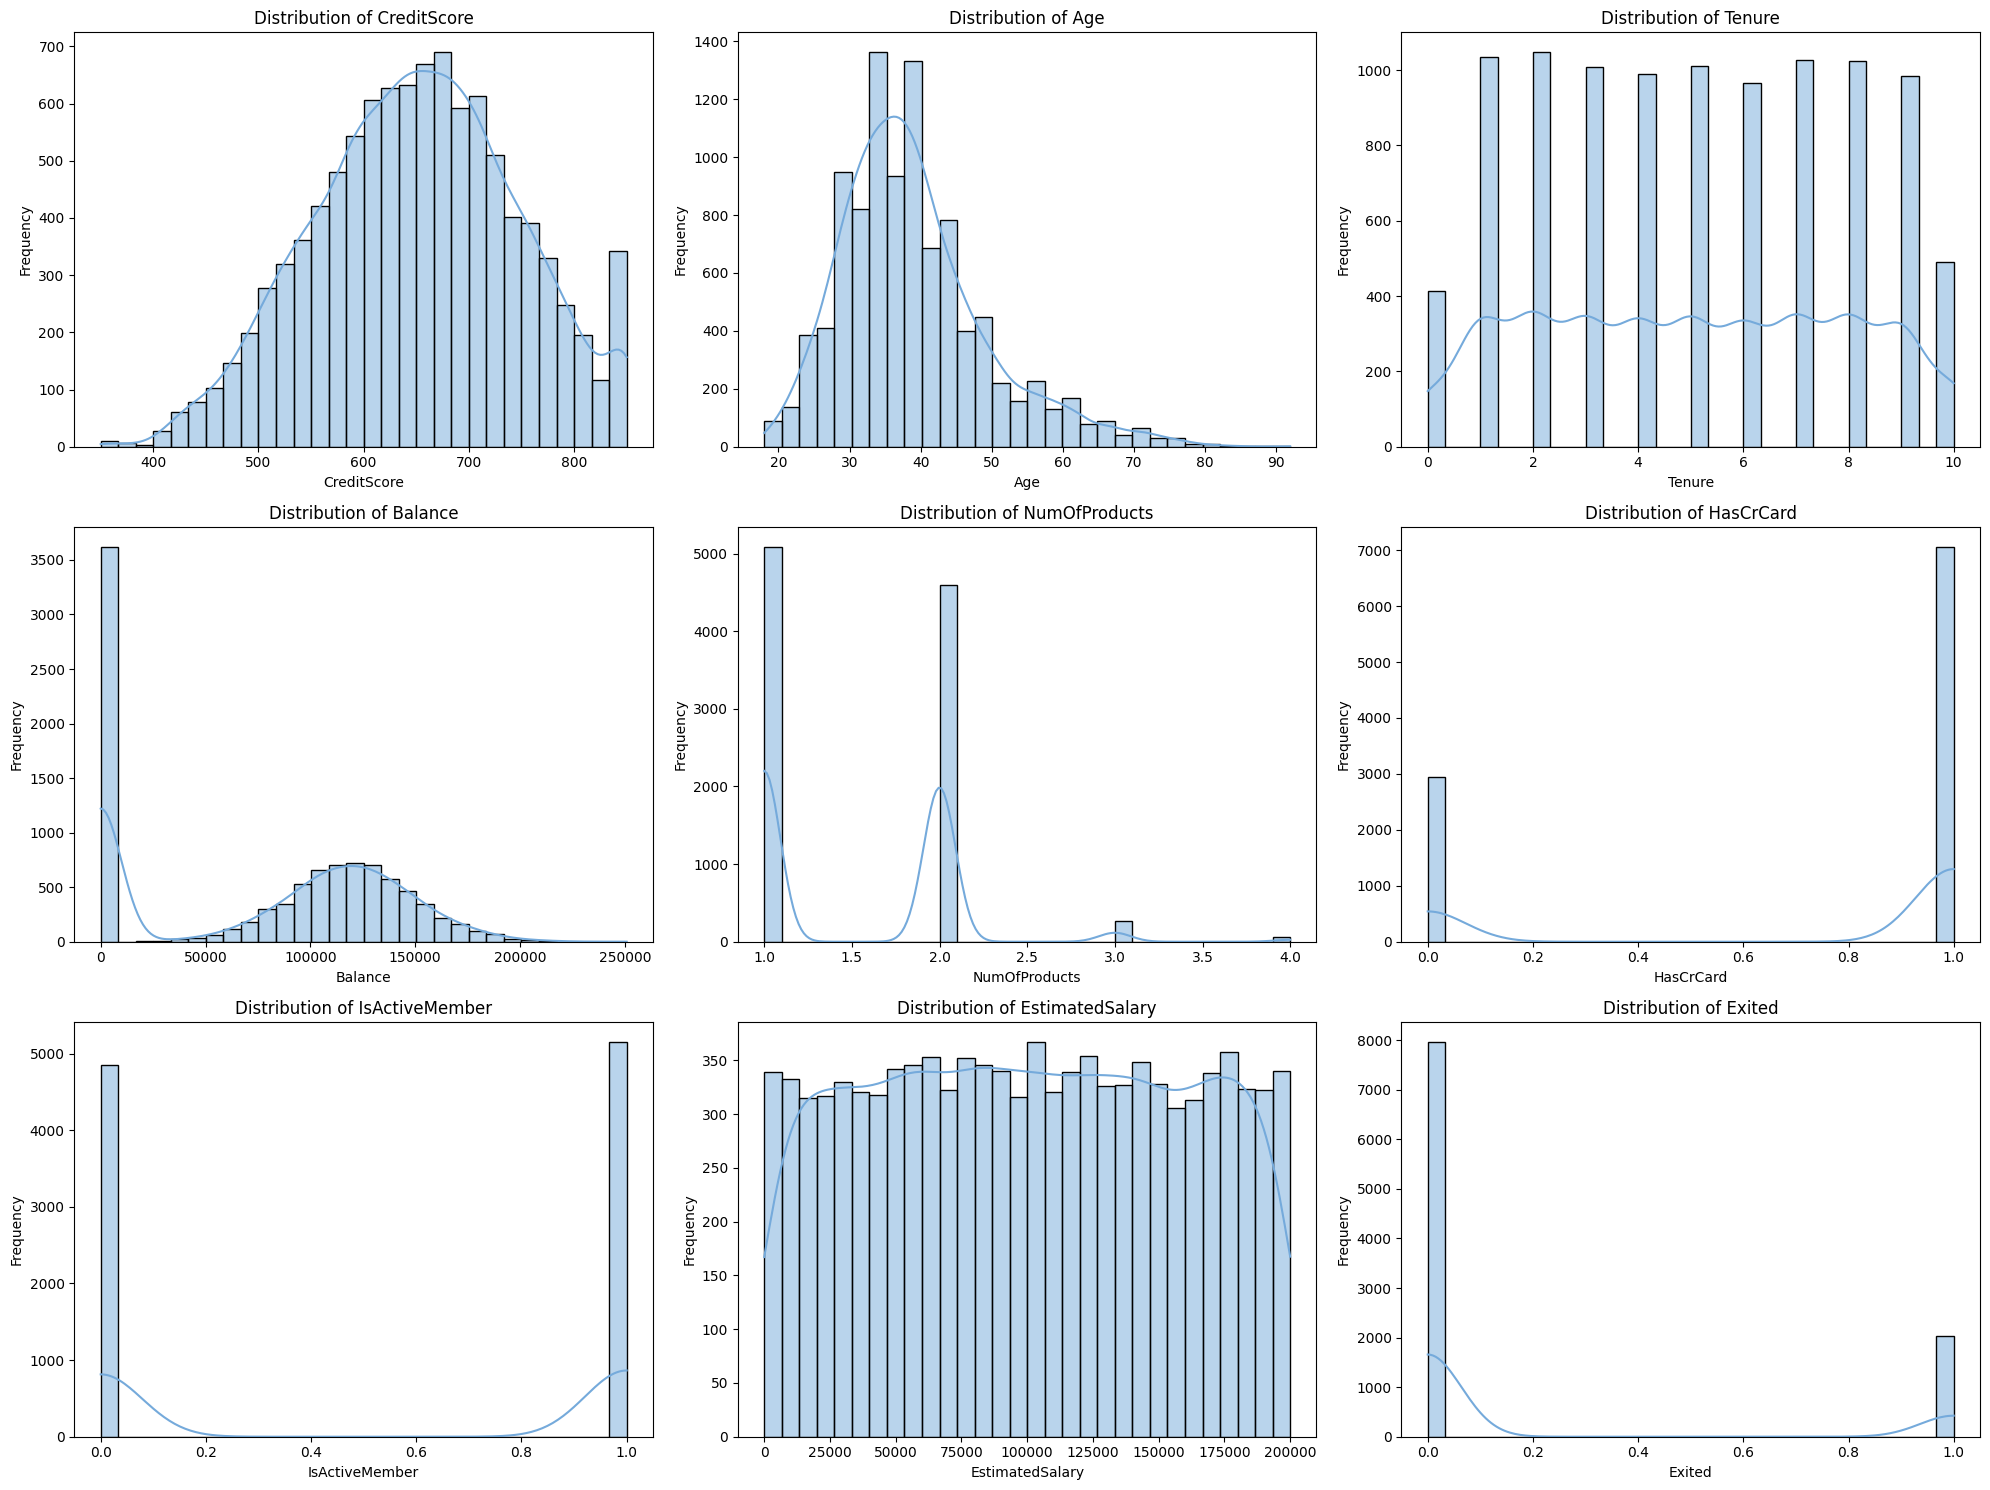

In [9]:
def numerical_univariate_analysis(df):
    

    print("\n### Numerical Univariate Analysis ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(20, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(num_columns):
        sns.histplot(df[col], kde=True, bins=30, color='#75aadb', ax=axes[i])  # Custom hex color
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()
numerical_univariate_analysis(df)



In [ ]:
def categorical_univariate_analysis(df):
   
    print("\n### Categorical Univariate Analysis ###")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    num_plots = len(cat_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(cat_columns):
        sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
        axes[i].set_title(f'Count of {col}')
        axes[i].set_xlabel('Count')
        axes[i].set_ylabel(col)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

categorical_univariate_analysis(df)



### Categorical Univariate Analysis ###


/tmp/ipykernel_9024/770034143.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
/tmp/ipykernel_9024/770034143.py:13: UserWarning: 
The palette list has fewer values (3) than needed (2932) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
/tmp/ipykernel_9024/770034143.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], palette=['#5e3023', '#c08552', '#f3e9dc'], ax=axes[i])  # Custom hex colors
/tmp/ipykernel_9024/770034143.py:13: FutureWarning: 

Passing `palette` without assi

In [ ]:
def pairplot_bivariate_analysis(df, target_column):
    print("\n### Pairplot Bivariate Analysis ###")
    
    # Use the custom color for the pairplot
    custom_color = '#758ecd'  # Updated color
    
    # Pair plot for numerical variables
    sns.pairplot(df, hue=target_column, diag_kind='kde')
    plt.suptitle("Pairplot of Numerical Features", y=1.02)
    plt.show()
pairplot_bivariate_analysis(df, target_column='Exited')


In [ ]:
def correlation_heatmap_bivariate_analysis(df):
    print("\n### Correlation Heatmap Bivariate Analysis ###")
    num_columns = df.select_dtypes(include=[np.number]).columns

    # Create the heatmap using the custom color palette
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_columns].corr(), annot=True, cmap=['#5dd9c1', '#acfcd9', '#b084cc', '#665687', '#190933'], fmt='.2f')
    plt.title("Correlation Matrix")
    plt.show()
correlation_heatmap_bivariate_analysis(df)


In [ ]:
def detect_outliers(df):
    print("\n### Outlier Detection ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    outliers_summary = {}
    for col in num_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers detected")
    return outliers_summary

detect_outliers(df)


In [ ]:
def box_plot_outlier_detection(df):
    
    print("\n### Box Plot for Outlier Detection ###")
    num_columns = df.select_dtypes(include=[np.number]).columns
    num_plots = len(num_columns)
    
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(num_columns):
        sns.boxplot(x=df[col], color='#758ecd', ax=axes[i])  # Custom color for the box plot
        axes[i].set_title(f'Box Plot of {col}')
        axes[i].set_xlabel(col)
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

box_plot_outlier_detection(df)


In [ ]:
def encode_categorical(df):
    print("\n### Encoding Categorical Variables ###")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
    print(f"Categorical columns encoded: {list(cat_columns)}")
    return df_encoded

df_encoded = encode_categorical(df)


In [ ]:
def encoded_feature_vs_target_analysis(df, target_column):
    
    print("\n### Encoded Feature vs Target Column Analysis ###")
    
    # Categorical features after encoding
    encoded_categorical_columns = ['Geography', 'Gender']
    num_plots = len(encoded_categorical_columns)
    
    rows = (num_plots // 2) + (num_plots % 2 > 0)
    
    fig, axes = plt.subplots(rows, 2, figsize=(14, rows * 5))
    axes = axes.flatten()
    
    for i, col in enumerate(encoded_categorical_columns):
        sns.countplot(x=df[col], hue=df[target_column], palette=['#6e5082', '#3a2b51', '#b084cc'], ax=axes[i])
        axes[i].set_title(f'Relationship between {col} and {target_column}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Define the target column
target_column = 'Exited'

# Call the function with the target column
encoded_feature_vs_target_analysis(df, target_column)


In [ ]:
def feature_engineering(df):
    print("\n### Feature Engineering ###")

    # 1. Example of creating an interaction feature (Age * Tenure)
    df['Age_Tenure'] = df['Age'] * df['Tenure']
    
    # 2. Creating a squared feature for Age to capture any non-linear relationship
    df['Age_Squared'] = df['Age'] ** 2

    # 3. Normalizing numerical columns (CreditScore, Balance, EstimatedSalary)
    
    scaler = StandardScaler()
    df[['CreditScore', 'Balance', 'EstimatedSalary']] = scaler.fit_transform(df[['CreditScore', 'Balance', 'EstimatedSalary']])

    # 4. Dropping the 'Surname' column as it is unlikely to be useful
    df.drop(columns=['Surname'], inplace=True)

    print("New feature columns added:", ['Age_Tenure', 'Age_Squared'])
feature_engineering(df)


In [ ]:

# Save the cleaned dataset as a CSV file
file_path = "../DataSet/cleaned_customer_churn_data.csv"
df.to_csv(file_path, index=False)

# Check the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Check if the file exists in the directory
if os.path.exists(file_path):
    print(f"File has been saved successfully at {file_path}")
else:
    print(f"File not found at {file_path}")

